#### Import packages and Library

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
#library
import library_final
from library_final.pokedex import DataLoader as ld
from library_final.pokedex import DataPreprocessor as nc
from library_final.pokedex import FeatureEng as en
from library_final.pokedex import ModelSelector as ml1


### Libraries for Database SQL
import pandas.io.sql as sqlio
import psycopg2
import json
from sqlalchemy import create_engine

#### Loading Datasets

  * Pokemon
  * Combats
  * Pokemon_id_each_team
  * Team_combat

In [2]:
## Load from Database
loader = ld.loader_database()
combats, pokemon, pokemon_id_each_team, team_combat, ProcessedData = loader.load_datasets()
## Load from repository
#loader = ld.loader_jupyter()
#combats, pokemon, pokemon_id_each_team, team_combat, Processed = loader.load_datasets()

#### Preprocessing & Feature Transformation

#### Numeric
1. Calculating Combat metrics
  * Victory_Rate
  * Total_Battles
  * Victory_Counts

2. Calculating pokemon skill levels
  * offensive_calculator
  * defensive_calculator
  * speed_power_ratio_calculator

#### Categorical
2. One hot encoding
  * Type 1
  * Type 2

3. Label Encoding
  * Legendary

In [3]:
## Creating new columns
combat_cols = nc.PokemonBattleProcessor(pokemon,combats)
combat_cols.process_battle_data()
pokemon_dt = combat_cols.get_processed_data()

In [4]:
pokemon_dt.head(5)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Victory_Rate,Total_Battles,Victory_Counts
0,1.0,Bulbasaur,Grass,Poison,45.0,49.0,49.0,65.0,65.0,45.0,1.0,False,0.278195,133.0,37.0
1,2.0,Ivysaur,Grass,Poison,60.0,62.0,63.0,80.0,80.0,60.0,1.0,False,0.380165,121.0,46.0
2,3.0,Venusaur,Grass,Poison,80.0,82.0,83.0,100.0,100.0,80.0,1.0,False,0.674242,132.0,89.0
3,4.0,Mega Venusaur,Grass,Poison,80.0,100.0,123.0,122.0,120.0,80.0,1.0,False,0.560000,125.0,70.0
4,5.0,Charmander,Fire,None,39.0,52.0,43.0,60.0,50.0,65.0,1.0,False,0.491071,112.0,55.0


In [5]:
#Setting Pokemon Calculator Class
offensive_calculator = nc.OffensivePowerCalculator(pokemon_dt)
defensive_calculator = nc.DefensivePowerCalculator(pokemon_dt)
speed_power_ratio_calculator = nc.SpeedToPowerRatioCalculator(pokemon_dt)

#Calculating Pokemon's OffensivePower
offensive_calculator.calculate()
#Calculating Pokemon's DefensivePower
defensive_calculator.calculate()
#Calculating Pokemon's SpeedToPower
speed_power_ratio_calculator.calculate()

In [9]:
#display new columns
pokemon_dt.iloc[:,12:].head(5)

,Victory_Rate,Total_Battles,Victory_Counts,Offensive_Power,Defensive_Power,Speed_to_Power_Ratio
0,0.278195,133.0,37.0,0.248473,0.189074,0.425051
1,0.380165,121.0,46.0,0.329279,0.252015,0.455788
2,0.674242,132.0,89.0,0.440622,0.337417,0.472856
3,0.560000,125.0,70.0,0.494838,0.405671,0.381560
4,0.491071,112.0,55.0,0.302877,0.152740,0.650838


In [10]:
#Checkpoint - Creating a Copy before starting one hot encoding
type_encoder = en.PokemonTypeEncoder(pokemon_dt)
#Create Dummies for Type 1 category variable
type_encoder.one_hot_encode_type1()
# Create new column only if the type doesn't exist
type_encoder.encode_type2()
# Return a new DataFrame with the update pokemon dataset + dummies
df = type_encoder.get_updated_dataframe()

In [11]:
#Label Encode Legendary Column
legend_encoder = en.Pokemon_Dummy_Legendary_Encoder(df)
legend_encoder.encode_legendary()

In [13]:
#display label encoding
df.iloc[:,11:].head(5)

,Legendary,Victory_Rate,Total_Battles,Victory_Counts,Offensive_Power,Defensive_Power,Speed_to_Power_Ratio,Bug,Dark,Dragon,...,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,0,0.278195,133.0,37.0,0.248473,0.189074,0.425051,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,0,0.380165,121.0,46.0,0.329279,0.252015,0.455788,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,0,0.674242,132.0,89.0,0.440622,0.337417,0.472856,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,0.560000,125.0,70.0,0.494838,0.405671,0.381560,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,0,0.491071,112.0,55.0,0.302877,0.152740,0.650838,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model Selection

1. Split Train and Test
2. Select Model
3. Train Model and Make Predictions
4. Model Evaluation
5. K_fold_cross_validation

In [16]:
# Dividing Dataset into Train and Test
Data_split = ml1.TrainTestDivider(df)
X_train, X_test, y_train, y_test, df_X, df_y = Data_split.train_test()

### Linear Regression
<h5> Here, we call the simple result method that fits, trains, predicts and shows us MSE and Rsquared from it; for any model

In [17]:
linear_reg_model = ml1.LinearRegressionAnalyzer()
linear_reg_model.set_data(X_train, y_train, X_test, y_test)
linear_reg_model.simple_result()

Model trained successfully.
Mean Squared Error: 0.009378679186597561 and R-squared: 0.8553790975705335


We can also plot the predictions, and fitted line, versus the actual values.

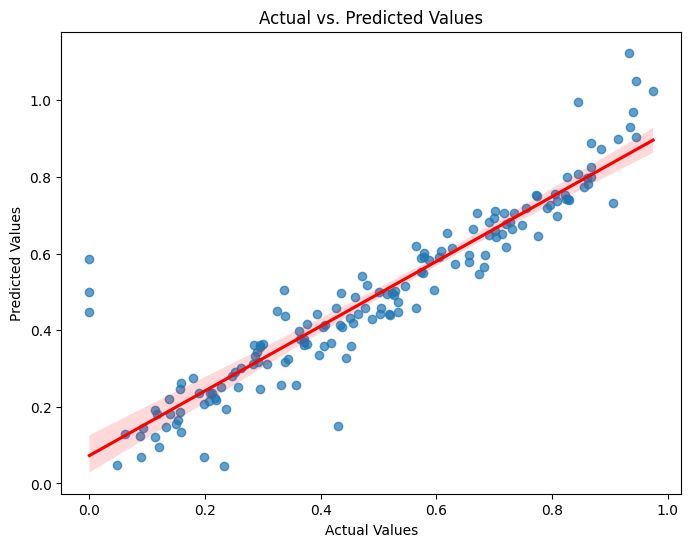

In [18]:
linear_reg_model.plot_actual_vs_predicted()

Another feature, cross validation

In [19]:
linreg_cv_results = linear_reg_model.k_fold_cross_validation()

Cross-Validation r_squared Scores: [0.79537089 0.81623163 0.8765056  0.8580887  0.82667499]
Mean Cross-Validation r_squared: 0.8345743623056245
Cross-Validation mse Scores: [0.01197154 0.01369227 0.00807676 0.01005418 0.01332962]
Mean Cross-Validation mse: 0.011424873643336645


#### Lasso Model simple.

In [20]:
# Step 1: Create an instance of LassoModel
lasso_model = ml1.LassoModel(np.linspace(0.001, 1, num=30))  

# Step 2: Run the Lasso model without cross-validation
lasso_model.set_data(X_train, y_train, X_test, y_test)
lasso_model.simple_result()

Model trained successfully.
Mean Squared Error: 0.009697404859753744 and R-squared: 0.8504642909584088


#### Doing cross validation

Optimal alpha after tuning: 0.001


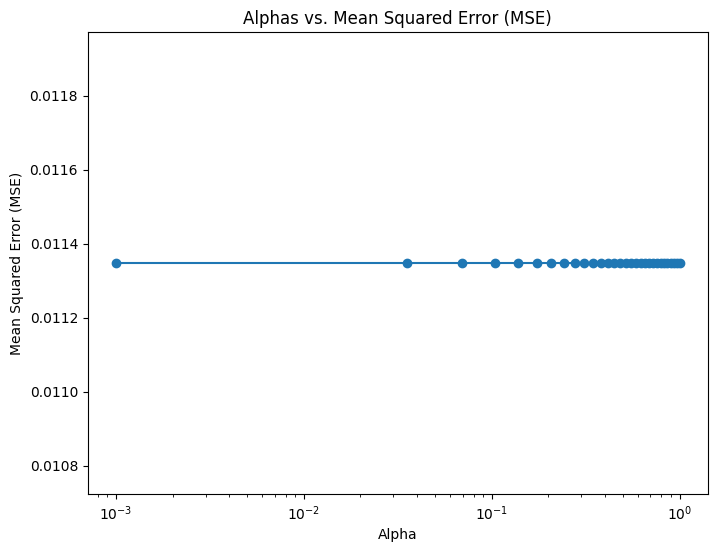

0.001

In [21]:
lasso_model.run_model_cv() 

#### Ridge Model simple

In [22]:
# Step 1: Create an instance of RidgeModel
ridge_model = ml1.RidgeModel(np.linspace(0.01, 100, num=30))  

# Step 2: Run the Ridge model without cross-validation
ridge_model.set_data(X_train, y_train, X_test, y_test)
ridge_model.simple_result()

Model trained successfully.
Mean Squared Error: 0.009378698262222273 and R-squared: 0.855378803421005


Optimal alpha after tuning: 41.3851724137931


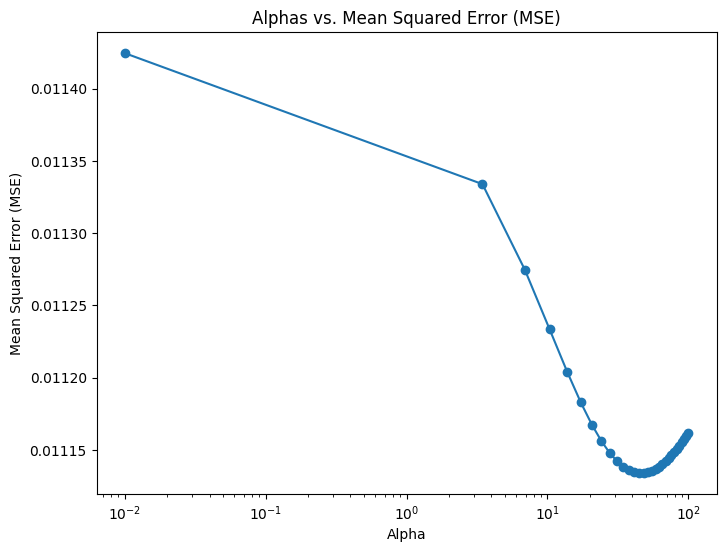

Cross-Validation r_squared Scores: [0.78417212 0.83889162 0.87457438 0.86891564 0.8220032 ]
Mean Cross-Validation r_squared: 0.8377113926830673
Cross-Validation mse Scores: [0.01262671 0.01200391 0.00820306 0.00928711 0.01368891]
Mean Cross-Validation mse: 0.011161939757213081


{'fit_time': array([0.00513506, 0.00313401, 0.00343585, 0.00357294, 0.00278711]),
 'score_time': array([0.002285  , 0.00232697, 0.00240803, 0.0019331 , 0.002002  ]),
 'test_r_squared': array([0.78417212, 0.83889162, 0.87457438, 0.86891564, 0.8220032 ]),
 'test_mse': array([0.01262671, 0.01200391, 0.00820306, 0.00928711, 0.01368891])}

In [23]:
ridge_model.run_model_cv() 

<h3> Random Forest

In [24]:
rf_model = ml1.RandomForestModel(n_estimators=100, max_depth=None, random_state=42)
rf_model.set_data(X_train, y_train, X_test, y_test)
rf_model.simple_result()

Model trained successfully.
Mean Squared Error: 0.009085907226757648 and R-squared: 0.8598936933036511


<h4>With cross validation

Cross-Validation r_squared Scores: [0.87621468 0.84371636 0.88294479 0.89382841 0.84045991]
Mean Cross-Validation r_squared: 0.8674328292402226
Cross-Validation mse Scores: [0.00724189 0.01164443 0.00765562 0.00752208 0.01226949]
Mean Cross-Validation mse: 0.009266701461648654


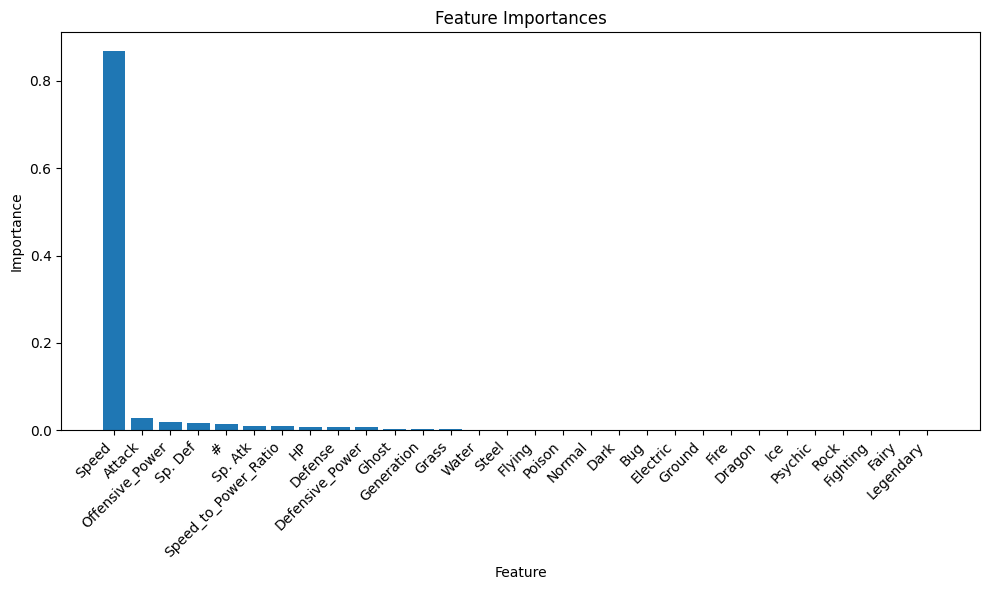

In [25]:
rf_cv_results = rf_model.k_fold_cross_validation()
feature_names = X_train.columns  
rf_model.plot_feature_importances(feature_names)